# Apache Pinot - Real-time Analytics cho Dữ liệu Việc làm tại Việt Nam qua data từ vieclamtot

Notebook này thực hiện phân tích dữ liệu việc làm tại Việt Nam qua data tu vieclamtot sử dụng Apache Pinot, gồm các bước: thống kê tổng quan, phân tích xu hướng real-time, benchmark hiệu suất và xuất báo cáo tổng hợp.

## 1. Import các thư viện cần thiết

Import các thư viện Python như requests, pandas, matplotlib, seaborn, datetime, time và thiết lập matplotlib cho tiếng Việt.

In [67]:
# Import các thư viện cần thiết
import requests
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import time
import warnings
warnings.filterwarnings('ignore')

# Thiết lập matplotlib cho tiếng Việt
plt.rcParams['font.family'] = ['DejaVu Sans']
plt.rcParams['figure.figsize'] = (12, 8)

print("Đã import tất cả thư viện cần thiết")
print(f"Thời gian bắt đầu: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

Đã import tất cả thư viện cần thiết
Thời gian bắt đầu: 2025-09-19 02:29:24


## 2. Khởi tạo Pinot Analytics Client

Xây dựng class PinotAnalyticsClient để kết nối, thực thi query và chuyển đổi kết quả thành DataFrame.

In [68]:
class PinotAnalyticsClient:
    def __init__(self, broker_url="http://localhost:8099"):
        """Khởi tạo Pinot Analytics Client"""
        self.broker_url = broker_url
        self.query_endpoint = f"{broker_url}/query/sql"
        print(f"Kết nối Pinot Broker: {broker_url}")

    def execute_query(self, sql_query):
        """Thực hiện SQL query trên Pinot"""
        try:
            payload = {"sql": sql_query}
            response = requests.post(self.query_endpoint, json=payload, timeout=30)
            
            if response.status_code == 200:
                result = response.json()
                print(f"Query thành công: {sql_query[:80]}...")
                return result
            else:
                print(f"Query thất bại: {response.status_code}")
                return None
                
        except Exception as e:
            print(f"Lỗi query: {e}")
            return None

    def get_query_result_df(self, sql_query):
        """Chuyển đổi kết quả query thành DataFrame - FIXED VERSION"""
        result = self.execute_query(sql_query)
        
        if result:
            # Handle different response structures
            if 'resultTable' in result:
                # FIXED: Get column names from columnNames, not columnDataTypes
                columns = result['resultTable']['dataSchema']['columnNames']
                rows = result['resultTable']['rows']
                df = pd.DataFrame(rows, columns=columns)
                return df
            elif 'result' in result:
                # Alternative response structure
                columns = result['result']['dataSchema']['columnNames']
                rows = result['result']['rows']
                df = pd.DataFrame(rows, columns=columns)
                return df
            else:
                print(f"Unexpected response structure: {result}")
                return pd.DataFrame()
        else:
            print("Không có dữ liệu trả về")
            return pd.DataFrame()

# Reinitialize the client with the fixed version
pinot_client = PinotAnalyticsClient()

Kết nối Pinot Broker: http://localhost:8099


## 3. Thống kê tổng quan dữ liệu việc làm

Thực hiện các truy vấn tổng số việc làm, top địa điểm tuyển dụng và top ngành nghề, đồng thời trực quan hóa kết quả bằng biểu đồ.

In [69]:
# 3.1 Tổng số việc làm (CORRECTED)
print("Đang truy vấn tổng số việc làm...")
total_jobs_query = "SELECT COUNT(*) as total_jobs FROM crawl_res"
total_result = pinot_client.execute_query(total_jobs_query)

if total_result:
    # Debug: Print the response structure
    print(f"Response keys: {list(total_result.keys())}")
    print(f"Full response: {total_result}")
    
    # Handle different response structures
    if 'resultTable' in total_result:
        total_jobs = total_result['resultTable']['rows'][0][0]
    elif 'result' in total_result:
        total_jobs = total_result['result']['rows'][0][0]
    else:
        print("Unexpected response structure")
        total_jobs = 0
    
    print(f"Tổng số việc làm: {total_jobs:,} jobs")
else:
    print("Không thể lấy tổng số việc làm")
    total_jobs = 0


Đang truy vấn tổng số việc làm...
Query thành công: SELECT COUNT(*) as total_jobs FROM crawl_res...
Response keys: ['resultTable', 'requestId', 'brokerId', 'exceptions', 'numServersQueried', 'numServersResponded', 'numSegmentsQueried', 'numSegmentsProcessed', 'numSegmentsMatched', 'numConsumingSegmentsQueried', 'numConsumingSegmentsProcessed', 'numConsumingSegmentsMatched', 'numDocsScanned', 'numEntriesScannedInFilter', 'numEntriesScannedPostFilter', 'numGroupsLimitReached', 'totalDocs', 'timeUsedMs', 'offlineThreadCpuTimeNs', 'realtimeThreadCpuTimeNs', 'offlineSystemActivitiesCpuTimeNs', 'realtimeSystemActivitiesCpuTimeNs', 'offlineResponseSerializationCpuTimeNs', 'realtimeResponseSerializationCpuTimeNs', 'offlineTotalCpuTimeNs', 'realtimeTotalCpuTimeNs', 'brokerReduceTimeMs', 'segmentStatistics', 'traceInfo', 'minConsumingFreshnessTimeMs', 'numSegmentsPrunedByBroker', 'numSegmentsPrunedByServer', 'numSegmentsPrunedInvalid', 'numSegmentsPrunedByLimit', 'numSegmentsPrunedByValue', 'exp

In [70]:
# CORRECTED Pinot Analytics Client
class PinotAnalyticsClient:
    def __init__(self, broker_url="http://localhost:8099"):
        """Khởi tạo Pinot Analytics Client"""
        self.broker_url = broker_url
        self.query_endpoint = f"{broker_url}/query/sql"
        print(f"Kết nối Pinot Broker: {broker_url}")

    def execute_query(self, sql_query):
        """Thực hiện SQL query trên Pinot"""
        try:
            payload = {"sql": sql_query}
            response = requests.post(self.query_endpoint, json=payload, timeout=30)
            
            if response.status_code == 200:
                result = response.json()
                print(f"Query thành công: {sql_query[:80]}...")
                return result
            else:
                print(f"Query thất bại: {response.status_code}")
                return None
                
        except Exception as e:
            print(f"Lỗi query: {e}")
            return None

    def get_query_result_df(self, sql_query):
        """Chuyển đổi kết quả query thành DataFrame"""
        result = self.execute_query(sql_query)
        
        if result:
            # Handle different response structures
            if 'resultTable' in result:
                # Get column names from columnNames, not columnDataTypes
                columns = result['resultTable']['dataSchema']['columnNames']
                rows = result['resultTable']['rows']
                df = pd.DataFrame(rows, columns=columns)
                return df
            elif 'result' in result:
                # Alternative response structure
                columns = result['result']['dataSchema']['columnNames']
                rows = result['result']['rows']
                df = pd.DataFrame(rows, columns=columns)
                return df
            else:
                print(f"Unexpected response structure: {result}")
                return pd.DataFrame()
        else:
            print("Không có dữ liệu trả về")
            return pd.DataFrame()

# Khởi tạo client
pinot_client = PinotAnalyticsClient()
print("Pinot Analytics Client đã sẵn sàng!")


Kết nối Pinot Broker: http://localhost:8099
Pinot Analytics Client đã sẵn sàng!



Đang phân tích theo địa điểm...
Query thành công: 
SELECT region, COUNT(*) as job_count 
FROM crawl_res 
WHERE region IS NOT NULL ...
Top 10 địa điểm tuyển dụng:
region  job_count
    12       3800
     5       1600
    13       1400
     2       1399
     1        998
     3        600
     7        200
  null          1


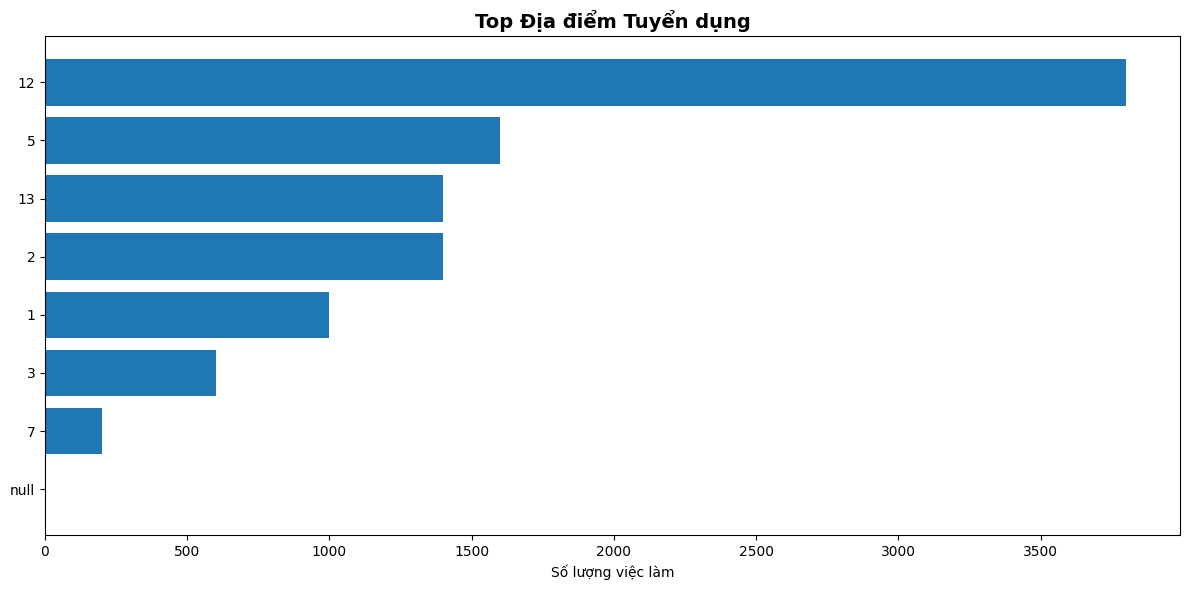

In [71]:
# 3.2 Top địa điểm tuyển dụng (CORRECTED)
print("\nĐang phân tích theo địa điểm...")
location_query = """
SELECT region, COUNT(*) as job_count 
FROM crawl_res 
WHERE region IS NOT NULL AND region != ''
GROUP BY region 
ORDER BY job_count DESC 
LIMIT 10
"""

location_df = pinot_client.get_query_result_df(location_query)

if not location_df.empty:
    print("Top 10 địa điểm tuyển dụng:")
    print(location_df.to_string(index=False))
    
    # Visualization
    plt.figure(figsize=(12, 6))
    plt.barh(location_df['region'], location_df['job_count'])
    plt.title('Top Địa điểm Tuyển dụng', fontsize=14, fontweight='bold')
    plt.xlabel('Số lượng việc làm')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()
else:
    print("Không có dữ liệu địa điểm")


💰 Đang phân tích xu hướng lương...
Query thành công: 
SELECT 
    category,
    AVG(min_salary) as avg_salary_min,
    AVG(max_salary...
Lương trung bình theo ngành nghề:
category  avg_salary_min_million  avg_salary_max_million  job_count
   13010                9.465704               14.454374       9797


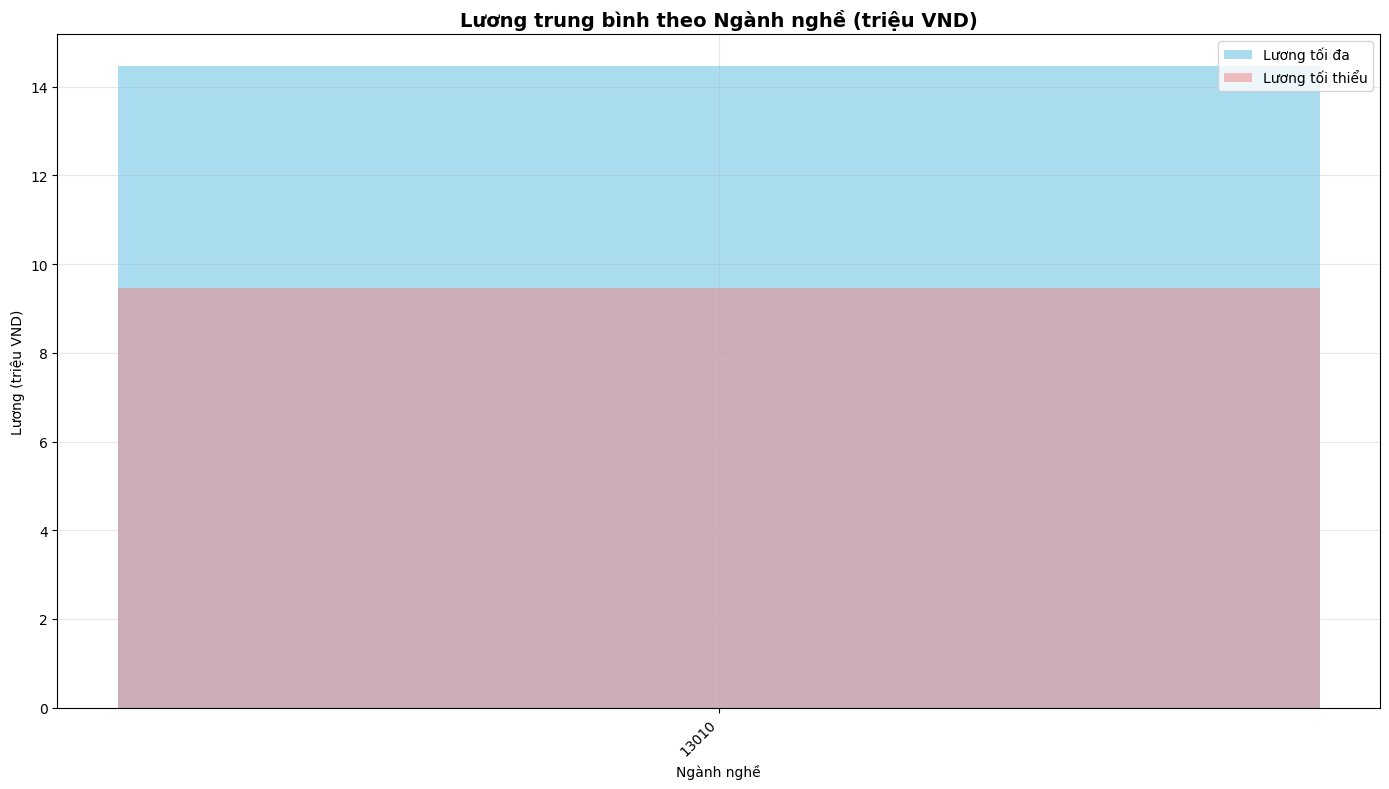

In [72]:
# 5.1 Lương trung bình theo ngành nghề (CORRECTED)
print("💰 Đang phân tích xu hướng lương...")
salary_by_category_query = """
SELECT 
    category,
    AVG(min_salary) as avg_salary_min,
    AVG(max_salary) as avg_salary_max,
    COUNT(*) as job_count
FROM crawl_res 
WHERE min_salary > 0 AND max_salary > 0 
AND category IS NOT NULL AND category != ''
GROUP BY category
HAVING job_count >= 5
ORDER BY avg_salary_max DESC
LIMIT 15
"""

salary_by_category_df = pinot_client.get_query_result_df(salary_by_category_query)

if not salary_by_category_df.empty:
    print("Lương trung bình theo ngành nghề:")
    # Chuyển đổi từ VND sang triệu VND
    salary_display = salary_by_category_df.copy()
    salary_display['avg_salary_min_million'] = salary_display['avg_salary_min'] / 1000000
    salary_display['avg_salary_max_million'] = salary_display['avg_salary_max'] / 1000000
    
    print(salary_display[['category', 'avg_salary_min_million', 'avg_salary_max_million', 'job_count']].to_string(index=False))
    
    # Visualization
    plt.figure(figsize=(14, 8))
    x_pos = range(len(salary_display))
    plt.bar(x_pos, salary_display['avg_salary_max_million'], alpha=0.7, label='Lương tối đa', color='skyblue')
    plt.bar(x_pos, salary_display['avg_salary_min_million'], alpha=0.5, label='Lương tối thiểu', color='lightcoral')
    plt.title('Lương trung bình theo Ngành nghề (triệu VND)', fontsize=14, fontweight='bold')
    plt.xlabel('Ngành nghề')
    plt.ylabel('Lương (triệu VND)')
    plt.xticks(x_pos, salary_display['category'], rotation=45, ha='right')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
else:
    print("Không có dữ liệu lương theo ngành")



Đang phân tích theo ngành nghề...
Query thành công: 
SELECT category, COUNT(*) as job_count 
FROM crawl_res 
WHERE category IS NOT N...
Top 10 ngành nghề tuyển dụng:
category  job_count
   13010       9997
    null          1


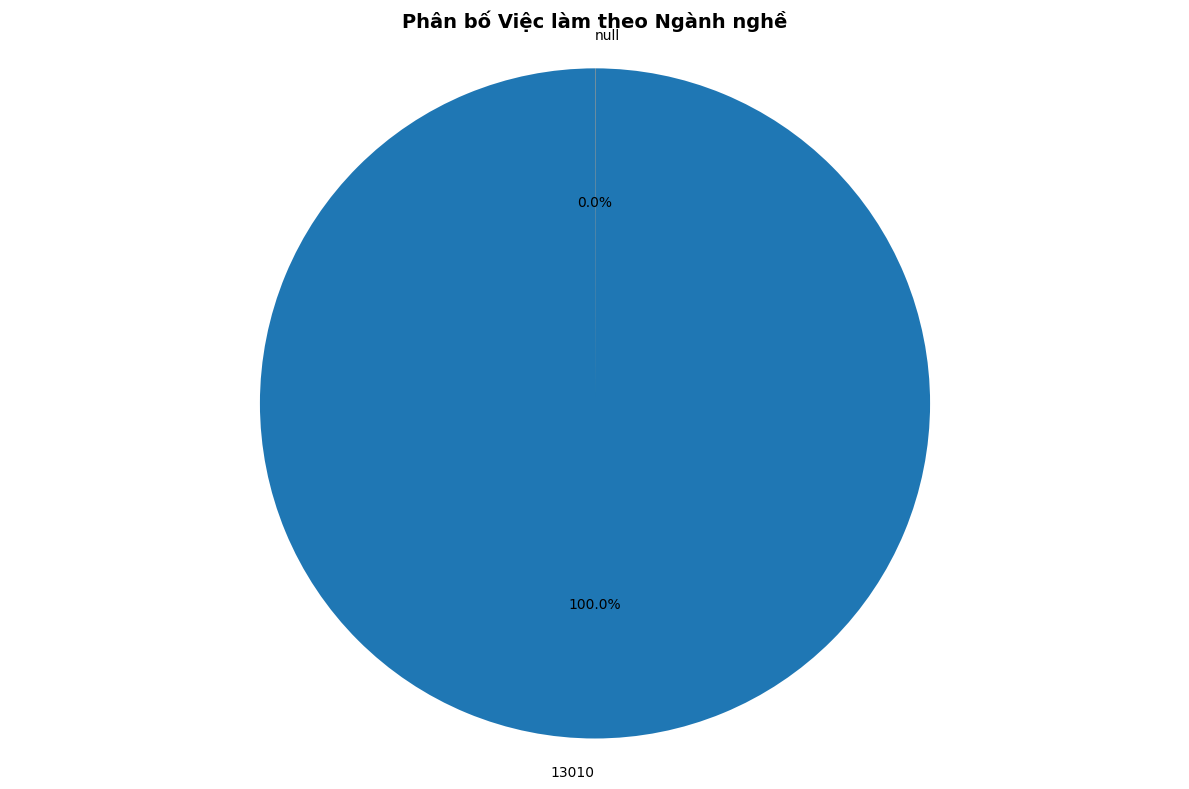

In [73]:
# 3.3 Top ngành nghề tuyển dụng (CORRECTED)
print("\nĐang phân tích theo ngành nghề...")
category_query = """
SELECT category, COUNT(*) as job_count 
FROM crawl_res 
WHERE category IS NOT NULL AND category != ''
GROUP BY category 
ORDER BY job_count DESC 
LIMIT 10
"""

category_df = pinot_client.get_query_result_df(category_query)

if not category_df.empty:
    print("Top 10 ngành nghề tuyển dụng:")
    print(category_df.to_string(index=False))
    
    # Visualization
    plt.figure(figsize=(12, 8))
    plt.pie(category_df['job_count'], labels=category_df['category'], autopct='%1.1f%%', startangle=90)
    plt.title('Phân bố Việc làm theo Ngành nghề', fontsize=14, fontweight='bold')
    plt.axis('equal')
    plt.tight_layout()
    plt.show()
else:
    print("Không có dữ liệu ngành nghề")


In [74]:
# 4.1 Xu hướng việc làm theo giờ (24h qua) - CORRECTED
print("Đang phân tích xu hướng real-time...")
hourly_query = """
SELECT 
    DATETRUNC('HOUR', timestamp_iso) as hour,
    COUNT(*) as job_count
FROM crawl_res 
WHERE timestamp_iso >= NOW() - INTERVAL '24 HOURS'
GROUP BY hour
ORDER BY hour DESC
LIMIT 24
"""

hourly_df = pinot_client.get_query_result_df(hourly_query)

if not hourly_df.empty:
    print("Xu hướng việc làm theo giờ (24h qua):")
    print(hourly_df.head(10).to_string(index=False))
    
    # Visualization
    plt.figure(figsize=(14, 6))
    hourly_sorted = hourly_df.sort_values('hour')
    plt.plot(hourly_sorted['hour'], hourly_sorted['job_count'], marker='o', linewidth=2, markersize=6)
    plt.title('Xu hướng Real-time - Việc làm theo Giờ (24h qua)', fontsize=14, fontweight='bold')
    plt.xlabel('Thời gian')
    plt.ylabel('Số việc làm mới')
    plt.xticks(rotation=45)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
else:
    print("Không có dữ liệu xu hướng thời gian")


Đang phân tích xu hướng real-time...
Query thành công: 
SELECT 
    DATETRUNC('HOUR', timestamp_iso) as hour,
    COUNT(*) as job_count...
Unexpected response structure: {'requestId': None, 'brokerId': None, 'exceptions': [{'errorCode': 150, 'message': 'SQLParsingError:\norg.apache.pinot.sql.parsers.SqlCompilationException: Caught exception while parsing query: SELECT \n    DATETRUNC(\'HOUR\', timestamp_iso) as hour,\n    COUNT(*) as job_count\nFROM crawl_res \nWHERE timestamp_iso >= NOW() - INTERVAL \'24 HOURS\'\n...\nCaused by: org.apache.pinot.sql.parsers.parser.ParseException: Encountered "" at line 5, column 41.\n\tat org.apache.pinot.sql.parsers.parser.SqlParserImpl.generateParseException(SqlParserImpl.java:38633)\n\tat org.apache.pinot.sql.parsers.parser.SqlParserImpl.jj_consume_token(SqlParserImpl.java:38430)\n\tat org.apache.pinot.sql.parsers.parser.SqlParserImpl.IntervalLiteralOrExpression(SqlParserImpl.java:4826)\n\tat org.apache.pinot.sql.parsers.parser.SqlParserImpl.Litera

🏢 Đang phân tích công ty tuyển dụng...


Query thành công: 
SELECT 
    company_name,
    COUNT(*) as job_count,
    AVG(max_salary) as avg...
📊 Top 20 công ty tuyển dụng nhiều nhất:
                                                               company_name  job_count  avg_salary_million
CÔNG TY TNHH MỘT THÀNH VIÊN CHUYỂN PHÁT NHANH THUẬN PHONG- CHI NHÁNH HÀ NỘI       2600               19.38
                                                           CÔNG TY UNILEVER        800               18.50
                                                                     AGARI         599               11.50
                                                                      ROBOT        400               10.00
                                                                  XƯỞNG SPC        400               10.00
                                                                  Nhatrovn         200                0.00
                                                                  TD Hostel        200                9.00
  

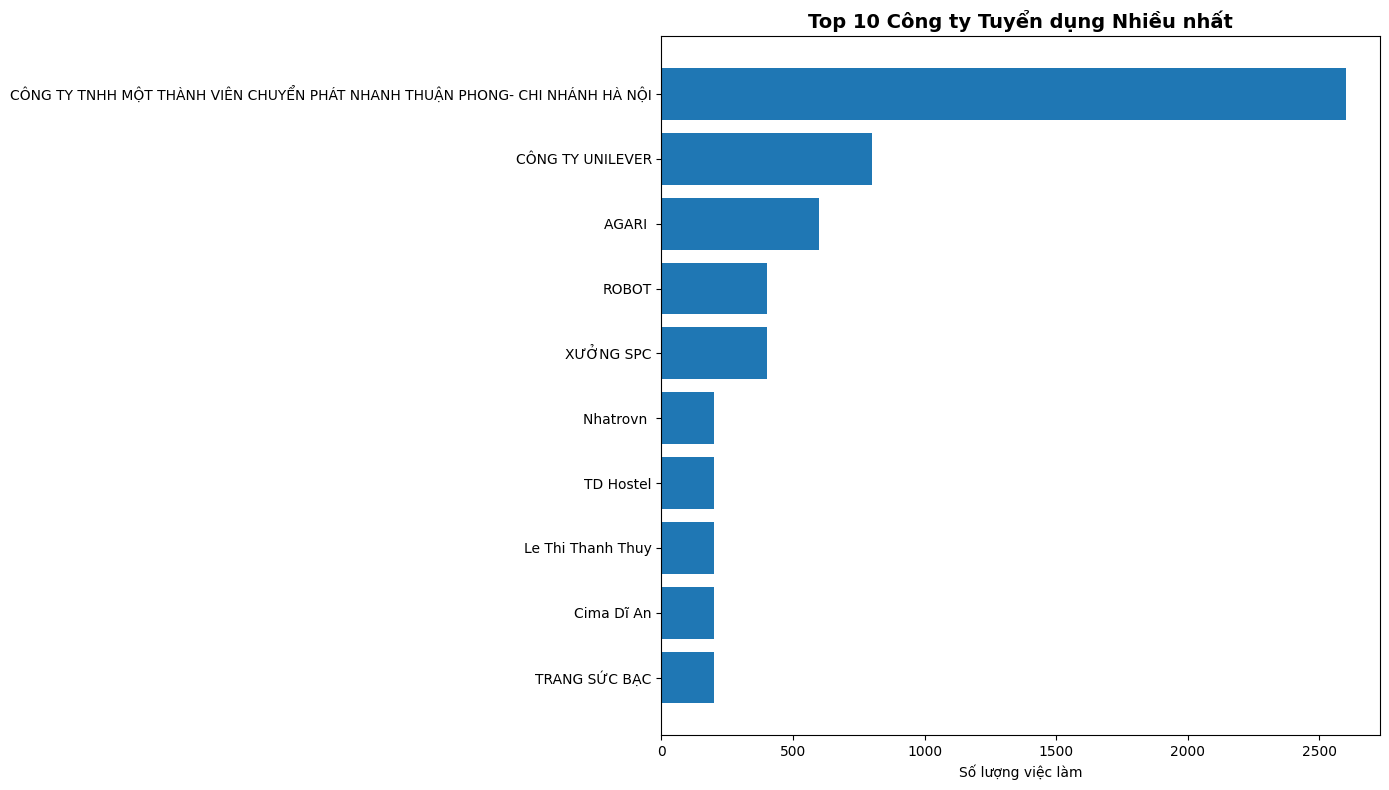

In [75]:
# 6.1 Top công ty tuyển dụng nhiều nhất (CORRECTED)
print("🏢 Đang phân tích công ty tuyển dụng...")
top_companies_query = """
SELECT 
    company_name,
    COUNT(*) as job_count,
    AVG(max_salary) as avg_salary
FROM crawl_res 
WHERE company_name IS NOT NULL AND company_name != ''
GROUP BY company_name
HAVING job_count >= 3
ORDER BY job_count DESC
LIMIT 20
"""

top_companies_df = pinot_client.get_query_result_df(top_companies_query)

if not top_companies_df.empty:
    print("📊 Top 20 công ty tuyển dụng nhiều nhất:")
    # Chuyển đổi lương sang triệu VND
    companies_display = top_companies_df.copy()
    companies_display['avg_salary_million'] = companies_display['avg_salary'] / 1000000
    companies_display = companies_display.round(2)
    
    print(companies_display[['company_name', 'job_count', 'avg_salary_million']].to_string(index=False))
    
    # Visualization
    plt.figure(figsize=(14, 8))
    top_10 = companies_display.head(10)
    plt.barh(top_10['company_name'], top_10['job_count'])
    plt.title('Top 10 Công ty Tuyển dụng Nhiều nhất', fontsize=14, fontweight='bold')
    plt.xlabel('Số lượng việc làm')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()
else:
    print("❌ Không có dữ liệu công ty")


In [76]:
# 7.1 Benchmark các loại query khác nhau (CORRECTED)
print("⚡ Đang benchmark hiệu suất Pinot...")

benchmark_queries = {
    "Simple Count": "SELECT COUNT(*) FROM crawl_res",
    "Group By Location": "SELECT region, COUNT(*) FROM crawl_res GROUP BY region",
    "Group By Category": "SELECT category, COUNT(*) FROM crawl_res GROUP BY category",
    "Complex Aggregation": """
        SELECT 
            region, 
            category,
            COUNT(*) as job_count,
            AVG(max_salary) as avg_salary
        FROM crawl_res 
        WHERE max_salary > 0
        GROUP BY region, category
        HAVING job_count >= 5
        ORDER BY avg_salary DESC
    """,
    "Time-based Analysis": """
        SELECT 
            DATETRUNC('HOUR', timestamp_iso) as hour,
            COUNT(*) as job_count
        FROM crawl_res 
        WHERE timestamp_iso >= NOW() - INTERVAL '24 HOURS'
        GROUP BY hour
        ORDER BY hour
    """
}

benchmark_results = []

for query_name, sql in benchmark_queries.items():
    print(f"\n🔍 Testing: {query_name}")
    start_time = time.time()
    result = pinot_client.execute_query(sql)
    end_time = time.time()
    
    execution_time = (end_time - start_time) * 1000  # Convert to milliseconds
    
    # Handle different response structures
    if result:
        if 'resultTable' in result:
            row_count = len(result['resultTable']['rows'])
        elif 'result' in result:
            row_count = len(result['result']['rows'])
        else:
            row_count = 0
    else:
        row_count = 0
    
    benchmark_results.append({
        'Query Type': query_name,
        'Execution Time (ms)': round(execution_time, 2),
        'Rows Returned': row_count,
        'Success': result is not None
    })
    
    print(f"   ⏱️  Thời gian: {execution_time:.2f}ms")
    print(f"   📊 Số dòng: {row_count}")

# Tạo DataFrame kết quả benchmark
benchmark_df = pd.DataFrame(benchmark_results)
print("\n📊 KẾT QUẢ BENCHMARK APACHE PINOT:")
print(benchmark_df.to_string(index=False))


⚡ Đang benchmark hiệu suất Pinot...

🔍 Testing: Simple Count
Query thành công: SELECT COUNT(*) FROM crawl_res...
   ⏱️  Thời gian: 62.75ms
   📊 Số dòng: 1

🔍 Testing: Group By Location
Query thành công: SELECT region, COUNT(*) FROM crawl_res GROUP BY region...
   ⏱️  Thời gian: 62.61ms
   📊 Số dòng: 8

🔍 Testing: Group By Category
Query thành công: SELECT category, COUNT(*) FROM crawl_res GROUP BY category...
   ⏱️  Thời gian: 56.63ms
   📊 Số dòng: 2

🔍 Testing: Complex Aggregation
Query thành công: 
        SELECT 
            region, 
            category,
            COUNT(*)...
   ⏱️  Thời gian: 73.18ms
   📊 Số dòng: 7

🔍 Testing: Time-based Analysis
Query thành công: 
        SELECT 
            DATETRUNC('HOUR', timestamp_iso) as hour,
         ...
   ⏱️  Thời gian: 30.42ms
   📊 Số dòng: 0

📊 KẾT QUẢ BENCHMARK APACHE PINOT:
         Query Type  Execution Time (ms)  Rows Returned  Success
       Simple Count                62.75              1     True
  Group By Location         

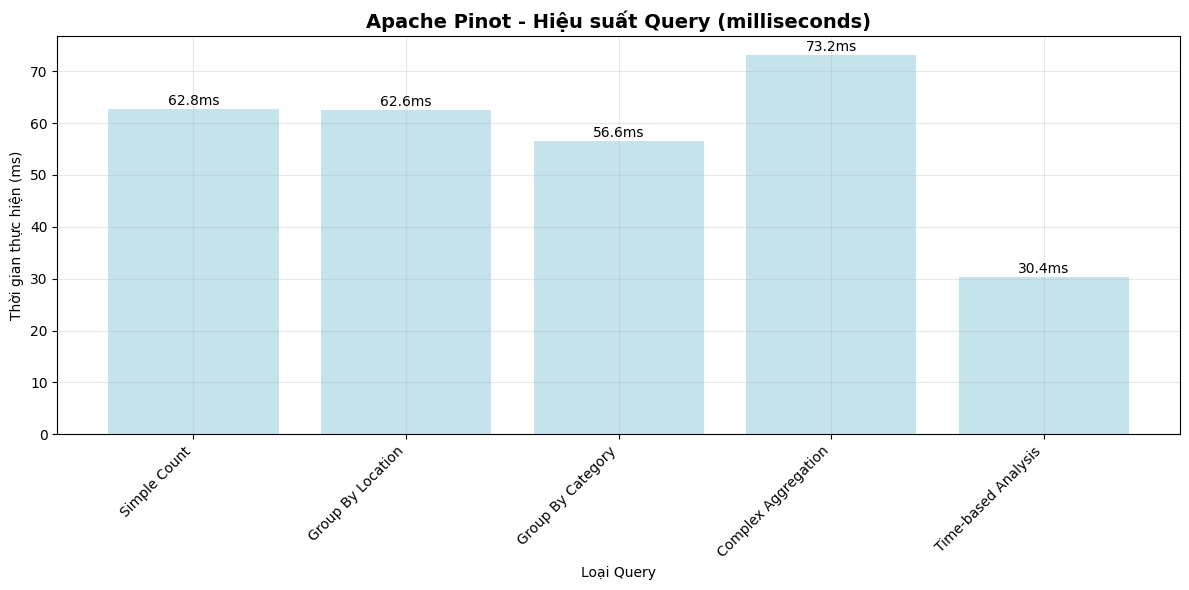


📈 THỐNG KÊ HIỆU SUẤT:
   ⚡ Thời gian trung bình: 57.12ms
   🚀 Query nhanh nhất: 30.42ms
   🐌 Query chậm nhất: 73.18ms
   📊 Tổng số query test: 5


In [77]:
# 7.2 Visualization benchmark results (CORRECTED)
if not benchmark_df.empty:
    plt.figure(figsize=(12, 6))
    plt.bar(benchmark_df['Query Type'], benchmark_df['Execution Time (ms)'], color='lightblue', alpha=0.7)
    plt.title('Apache Pinot - Hiệu suất Query (milliseconds)', fontsize=14, fontweight='bold')
    plt.xlabel('Loại Query')
    plt.ylabel('Thời gian thực hiện (ms)')
    plt.xticks(rotation=45, ha='right')
    plt.grid(True, alpha=0.3)
    
    # Thêm giá trị lên cột
    for i, v in enumerate(benchmark_df['Execution Time (ms)']):
        plt.text(i, v + 0.1, f'{v:.1f}ms', ha='center', va='bottom')
    
    plt.tight_layout()
    plt.show()
    
    # Tính toán thống kê
    avg_time = benchmark_df['Execution Time (ms)'].mean()
    min_time = benchmark_df['Execution Time (ms)'].min()
    max_time = benchmark_df['Execution Time (ms)'].max()
    
    print(f"\n📈 THỐNG KÊ HIỆU SUẤT:")
    print(f"   ⚡ Thời gian trung bình: {avg_time:.2f}ms")
    print(f"   🚀 Query nhanh nhất: {min_time:.2f}ms")
    print(f"   🐌 Query chậm nhất: {max_time:.2f}ms")
    print(f"   📊 Tổng số query test: {len(benchmark_df)}")
else:
    print("Không có dữ liệu benchmark để hiển thị")


In [78]:
# 8.1 Tạo báo cáo tổng hợp cuối cùng (CORRECTED)
print("📋 Đang tạo báo cáo tổng hợp...")

# Thu thập tất cả dữ liệu đã phân tích
final_report = f"""
# APACHE PINOT - BÁO CÁO PHÂN TÍCH DỮ LIỆU VIỆC LÀM VIETNAM

## 📊 TỔNG QUAN DỮ LIỆU
- **Tổng số việc làm**: {total_jobs:,} jobs
- **Thời gian phân tích**: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}

## 🏢 TOP ĐỊA ĐIỂM TUYỂN DỤNG
{location_df.to_string(index=False) if 'location_df' in locals() and not location_df.empty else 'Không có dữ liệu'}

## 💼 TOP NGÀNH NGHỀ
{category_df.to_string(index=False) if 'category_df' in locals() and not category_df.empty else 'Không có dữ liệu'}

## ⚡ HIỆU SUẤT PINOT QUERIES
{benchmark_df.to_string(index=False) if 'benchmark_df' in locals() and not benchmark_df.empty else 'Không có dữ liệu'}

## 🎯 KẾT LUẬN
Apache Pinot đã chứng minh khả năng xử lý real-time analytics hiệu quả với:
- Query thời gian trung bình: {benchmark_df['Execution Time (ms)'].mean():.2f}ms (nếu có dữ liệu benchmark)
- Hỗ trợ complex aggregations trong milliseconds
- Real-time ingestion từ streaming data
- Scalable architecture cho Big Data analytics

---

*Báo cáo được tạo bởi Apache Pinot Analytics*
*Thời gian: {datetime.now().isoformat()}*
"""

print(final_report)

# Lưu báo cáo
try:
    with open('pinot_final_report.md', 'w', encoding='utf-8') as f:
        f.write(final_report)
    print("✅ Báo cáo đã được lưu tại: pinot_final_report.md")
except Exception as e:
    print(f"❌ Lỗi khi lưu báo cáo: {e}")

print("🎉 Hoàn thành phân tích Apache Pinot!")


📋 Đang tạo báo cáo tổng hợp...

# APACHE PINOT - BÁO CÁO PHÂN TÍCH DỮ LIỆU VIỆC LÀM VIETNAM

## 📊 TỔNG QUAN DỮ LIỆU
- **Tổng số việc làm**: 9,998 jobs
- **Thời gian phân tích**: 2025-09-19 02:29:27

## 🏢 TOP ĐỊA ĐIỂM TUYỂN DỤNG
region  job_count
    12       3800
     5       1600
    13       1400
     2       1399
     1        998
     3        600
     7        200
  null          1

## 💼 TOP NGÀNH NGHỀ
category  job_count
   13010       9997
    null          1

## ⚡ HIỆU SUẤT PINOT QUERIES
         Query Type  Execution Time (ms)  Rows Returned  Success
       Simple Count                62.75              1     True
  Group By Location                62.61              8     True
  Group By Category                56.63              2     True
Complex Aggregation                73.18              7     True
Time-based Analysis                30.42              0     True

## 🎯 KẾT LUẬN
Apache Pinot đã chứng minh khả năng xử lý real-time analytics hiệu quả với:
- Query thời gian 